# Tutorial 6: Implementing and investigating the WMB method

In this tutorial, we will consider the implementation within the `pyslfp` framework of the method of Wahr, Molenaar, and Byran (1998) for estimating surface mass changes from GRACE gravity measurements. This is a simple and widely used method, but it is subject to some limitations that are not well appreciated. 

The idea underlying the method is the following relation between loads and gravitational gravational potential perturbations in the spherical harmonic domain:
$$
\phi_{lm} = k_{l} \sigma_{lm}.
$$
Here $\phi_{lm}$ are the spherical harmonic coefficients of the gravitational potential, $\sigma_{lm}$ the corresponding coefficients for the load, and $k_{l}$
the appropriate Love numbers that account both the direct mass associated with the load and the mass perturbations induced through the resulting deformation. 

Supposing we have observations of the gravitational potential over some range of degrees, we can use the above identity to approximately recover the load
through
$$
\sigma \approx \sum_{lm} k_{l}^{-1} \phi_{lm}, 
$$
where the summation is implicitly taken over only the degree for which we have observations. It should be noted that GRACE data cannot provide degree-one coefficients of gravity as these are associated with geo-centre motions to which the satellite orbit is insenitive. The degree zero coefficient  is also absent from the sum because its value must vanishes due to conservation of surface mass. As a result, we may assume that the above summation involves degrees in the range $2 \le l \le l_{\mathrm{obs}}$ where $l_{\mathrm{obs}}$ is the maximum observed degree. 

## Generating synthetic data

As a starting point, we will generate a synthetic data set of gravity observations for a known load. The first step is to set up an instance of the fingerprint class in the usual manner.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import pyslfp as sl
import pygeoinf as inf
import cartopy.crs as ccrs

# Initialize the core fingerprint model - lower lmax to reduce calculation times for this tutorial.
fp = sl.FingerPrint(
    lmax=256,
    earth_model_parameters=sl.EarthModelParameters.from_standard_non_dimensionalisation(),
)
fp.set_state_from_ice_ng()

We will suppose that the total surface load has components linked to changes in the ocean sheets, the oceans, and the continents. Due to the different physical processes involved, the spatial characteristic and amplitudes of these loads need not be the same. As a result, we will not model the load as a single spatial fiedl but rather as three indepedent fields restricted to their respective domains. 

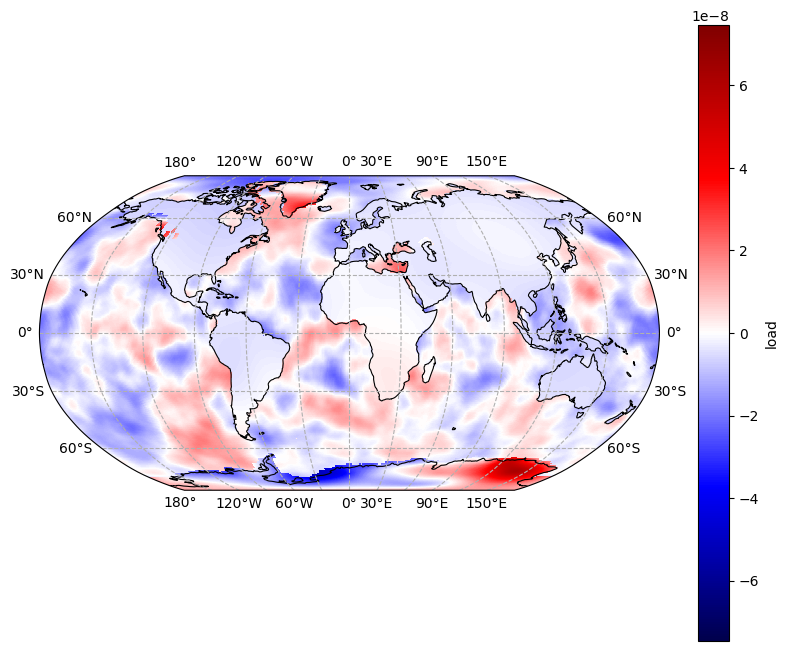

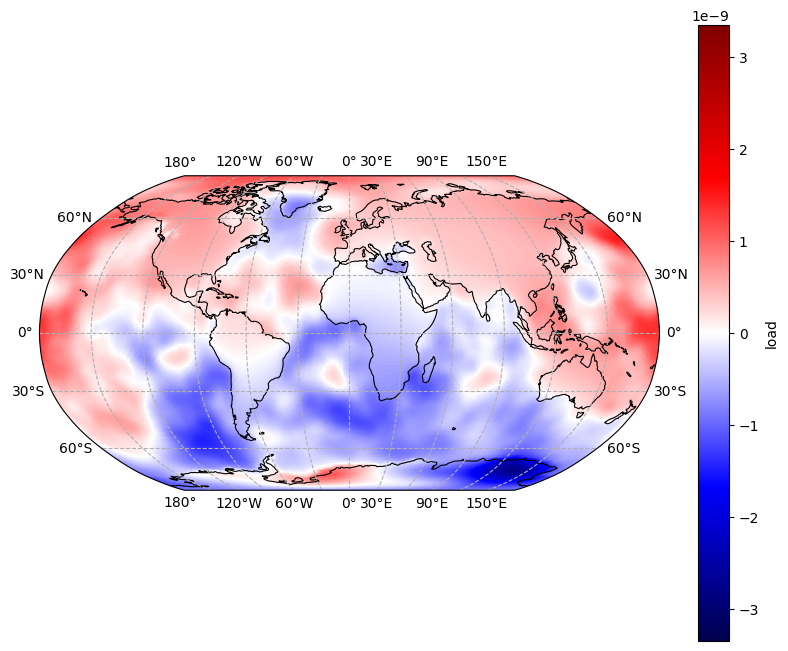

In [ ]:
# Define a space for the loads
order = 2.0
scale_km = 500.0
scale = scale_km * 1000 / fp.length_scale

load_space = inf.symmetric_space.sphere.Sobolev(
    fp.lmax, order, scale, radius=fp.mean_sea_floor_radius
)

# Define projection operators for the three regions
ice_projection = sl.ice_projection_operator(fp, load_space)
ocean_projection = sl.ocean_projection_operator(fp, load_space, exclude_ice_shelves=True)
land_projection = sl.land_projection_operator(fp, load_space, exclude_ice=True)

# Set Gaussian measure for the ice load
ice_order = 2
ice_scale_km = 500.0
ice_scale = ice_scale_km * 1000 / fp.length_scale
ice_thickness_amplitude_m = 0.2
ice_load_amplitude = fp.ice_density * (ice_thickness_amplitude_m /fp.length_scale)
intitial_ice_measure = load_space.point_value_scaled_sobolev_kernel_gaussian_measure(ice_order, ice_scale, ice_load_amplitude)
ice_measure = intitial_ice_measure.affine_mapping(operator=ice_projection)

# Set Gaussian measure for the ocean load
ocean_order = 1
ocean_scale_km = 500.0
ocean_scale = ocean_scale_km * 1000 / fp.length_scale
ocean_thickness_amplitude_m = 0.05
ocean_load_amplitude = fp.water_density * (ocean_thickness_amplitude_m /fp.length_scale)
intitial_ocean_measure = load_space.point_value_scaled_sobolev_kernel_gaussian_measure(ocean_order, ocean_scale, ocean_load_amplitude)
ocean_measure = intitial_ocean_measure.affine_mapping(operator=ocean_projection)


# Set Gaussian measure for the land load
land_order = 3
land_scale_km = 2000.0
land_scale = land_scale_km * 1000 / fp.length_scale
land_thickness_amplitude_m = 0.02
land_load_amplitude = fp.water_density * (land_thickness_amplitude_m /fp.length_scale)
intitial_land_measure = load_space.point_value_scaled_sobolev_kernel_gaussian_measure(land_order, land_scale, land_load_amplitude)
land_measure = intitial_land_measure.affine_mapping(operator=land_projection)


# Combine the load and measures.
loads_space = inf.HilbertSpaceDirectSum([load_space, load_space, load_space])
loads_to_load = loads_space.subspace_projection(0) + loads_space.subspace_projection(1) + loads_space.subspace_projection(2)
loads_measure = inf.GaussianMeasure.from_direct_sum([ice_measure, ocean_measure, land_measure])
load_measure = loads_measure.affine_mapping(operator=loads_to_load)


# Plot a sample load. 
load = load_measure.sample()

fig1, ax1, im1 = sl.plot(
    load,
    coasts=True,
    cmap="seismic",
    symmetric=True
)
fig1.colorbar(im1, ax=ax1, label="load")


A = fp.as_sobolev_linear_operator(2, 0.1*fp.mean_sea_floor_radius, rtol=1e-9)
_, gravitational_potential_change, _, _ = A(load)


fig2, ax2, im2 = sl.plot(
    gravitational_potential_change,
    coasts=True,
    cmap="seismic",
    symmetric=True
)
fig2.colorbar(im2, ax=ax2, label="gravitational potential change")

plt.show()





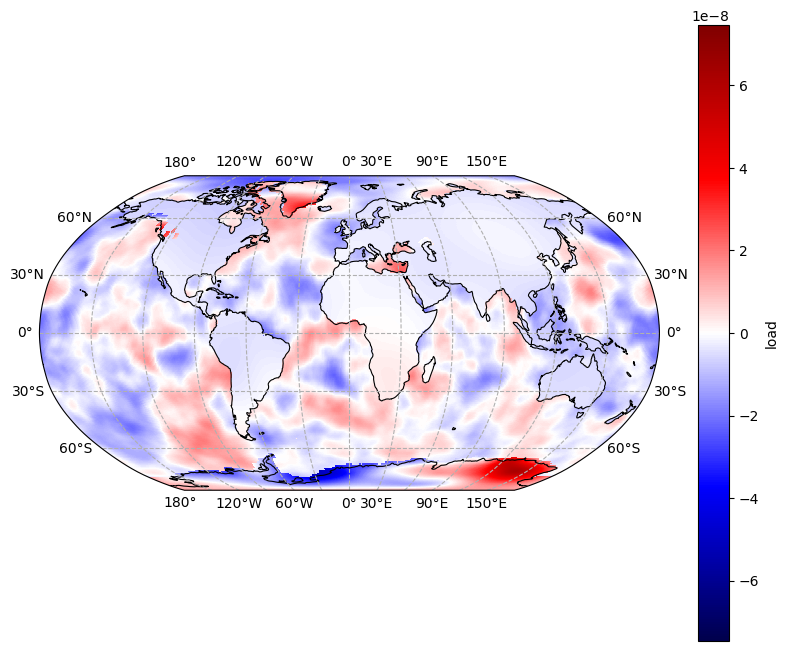

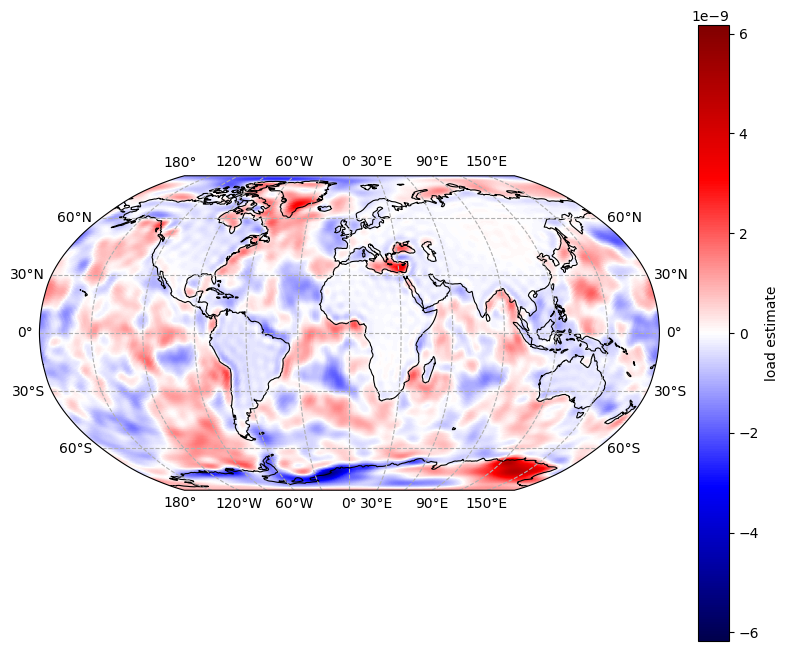

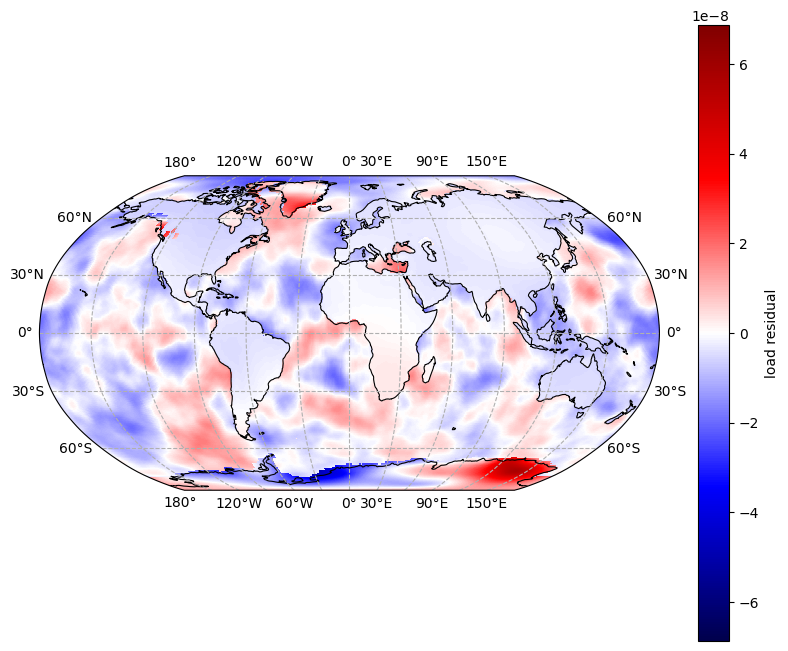

In [7]:
observation_degree = 60
wmb_method = sl.WMBMethod.from_finger_print(observation_degree, fp)

potential_space = A.codomain.subspace(2)
B = wmb_method.potential_field_to_load_operator(potential_space, load_space)

load_estimate = B(gravitational_potential_change)

fig1, ax1, im1 = sl.plot(
    load,
    coasts=True,
    cmap="seismic",
    symmetric=True
)
fig1.colorbar(im1, ax=ax1, label="load")

fig2, ax2, im2 = sl.plot(
    load_estimate,
    coasts=True,
    cmap="seismic",
    symmetric=True
)
fig2.colorbar(im2, ax=ax2, label="load estimate")



fig3, ax3, im3 = sl.plot(
    load-load_estimate,
    coasts=True,
    cmap="seismic",
    symmetric=True
)
fig3.colorbar(im3, ax=ax3, label="load residual")




plt.show()